In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def imhist(arr):
    hist = np.zeros((256), dtype=np.uint32)
    for item in arr.copy().reshape(-1):
        hist[item] += 1 
    return hist


def im2dhist(image, w_neighboring = 6):
    V = image.copy()
    [h, w] = V.shape
    V_hist = imhist(V)
    
    X = (V_hist>0) * np.arange(1, 257)
    X = X[X>0]
    K = len(X)

    Hist2D = np.zeros((K, K))
    
    X_inv = np.zeros((X[-1], 1), dtype=np.uint8).reshape(-1)
    X_inv[X-1] = np.arange(1, K+1)
    
    for i in range(K):
        [xi, yi] = np.where(V==(X[i]-1))
        
        xi_n = np.zeros((xi.size, 2*w_neighboring+1), dtype=np.int16)
        yi_n = np.zeros((yi.size, 2*w_neighboring+1), dtype=np.int16)
        for ii in range(2*w_neighboring+1):
            xi_n[:, ii] = xi + (ii - w_neighboring)
            yi_n[:, ii] = yi + (ii - w_neighboring)
    
        
        xi_n = np.where(xi_n<h, xi_n, -1*np.ones_like(xi_n))
        yi_n = np.where(yi_n<w, yi_n, -1*np.ones_like(yi_n))
        
        
        for i_row in range(xi_n.shape[0]):
            xi_nr = xi_n[i_row, :].copy() 
            yi_nr = yi_n[i_row, :].copy() 
            xi_nr = xi_nr[np.where(xi_nr>=0)].copy()
            yi_nr = yi_nr[np.where(yi_nr>=0)].copy()
            
            neighboring_intens = V[xi_nr[0]:xi_nr[-1]+1, yi_nr[0]:yi_nr[-1]+1].copy().reshape(-1).astype(np.int16)
            
            for neighboring_inten in neighboring_intens:
                    Hist2D[i, X_inv[neighboring_inten]-1] += np.abs(neighboring_inten+1-X[i]) +1
    # Hist2D_normalized = Hist2D/np.sum(Hist2D)
    return Hist2D


def plot2dhist(Hist2D, title):
    # plot 2D-Histogram
    [K, _] = Hist2D.shape
    x = np.outer(np.arange(0, K), np.ones(K))
    y = x.copy().T 
    # ln-ing Hist2D makes its details more prominent.
    Hist2D_ln = Hist2D.copy()
    Hist2D_ln[np.where(Hist2D_ln<=0)] = 1e-15
    z = np.log(Hist2D_ln)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(x, y, z,cmap='viridis', edgecolor='none')
    ax.set_title(title)
    plt.show()
    
def im2dhisteq(image, hist2d):
    V = image.copy()
    [h, w] = V.shape
    V_hist = imhist(V)
    H_in = hist2d/np.sum(hist2d)
    CDFx = np.cumsum(np.sum(H_in, axis=0)) # Kx1

    # normalizes CDFx
    CDFxn = (255*CDFx/CDFx[-1])

    PDFxn = np.zeros_like(CDFxn)
    PDFxn[0] = CDFxn[0]
    PDFxn[1:] = np.diff(CDFxn)

    X_transform = np.zeros((256))
    X_transform[np.where(V_hist > 0)] = PDFxn.copy()
    CDFxn_transform = np.cumsum(X_transform)


    # bins = np.array([i for i in range(0, 256)])
    bins = np.arange(256)
    # uses linear interpolation of cdf to find new pixel values
    image_equalized = np.floor(np.interp(V.flatten(), bins, CDFxn_transform).reshape(h, w)).astype(np.uint8)

    return image_equalized

def multi2dhist(image):
    return im2dhist(image, w_neighboring=0), im2dhist(image, w_neighboring=3), im2dhist(image, w_neighboring=7)

def get_map(Y_1, Y_3, Y_5, hist2d_1, hist2d_3, hist2d_5):
    Y_hist_1 = imhist(Y_1)
    y_hist_1 = (Y_hist_1>0) * np.arange(1,257)
    y_hist_1 = y_hist_1[y_hist_1>0]
    L_1 = len(y_hist_1)

    Y_hist_3 = imhist(Y_3)
    y_hist_3 = (Y_hist_3>0) * np.arange(1,257)
    y_hist_3 = y_hist_3[y_hist_3>0]
    L_3 = len(y_hist_3)

    Y_hist_5 = imhist(Y_5)
    y_hist_5 = (Y_hist_5>0) * np.arange(1,257)
    y_hist_5 = y_hist_5[y_hist_5>0]
    L_5 = len(y_hist_5)

    P_t_1 = np.full((L_1), 1/L_1)
    P_t_3 = np.full((L_3), 1/L_3)
    P_t_5 = np.full((L_5), 1/L_5)

    P_x_1 = np.sum(hist2d_1/np.sum(hist2d_1), axis=0)
    P_x_3 = np.sum(hist2d_3/np.sum(hist2d_3), axis=0)
    P_x_5 = np.sum(hist2d_5/np.sum(hist2d_5), axis=0)
    
    mapxy_1 = []
    for m in range(len(P_x_1)):
        P_t_copy_1 = P_t_1.copy()
        P_t_copy_1 *= L_1
        m_prime = np.min(abs(P_x_1[m] - P_t_copy_1))
        mapxy_1.append(m_prime)
    mapxy_1 = np.sort(mapxy_1)
    
    mapxy_3 = []
    for m in range(len(P_x_3)):
        P_t_copy_3 = P_t_3.copy()
        P_t_copy_3 *= L_3
        m_prime = np.min(abs(P_x_3[m] - P_t_copy_3))
        mapxy_3.append(m_prime)
    mapxy_3 = np.sort(mapxy_3)

    mapxy_5 = []
    for m in range(len(P_x_5)):
        P_t_copy_5 = P_t_5.copy()
        P_t_copy_5 *= L_5
        m_prime = np.min(abs(P_x_5[m] - P_t_copy_5))
        mapxy_5.append((m_prime))
    mapxy_5 = np.sort(mapxy_5) 
    
    return mapxy_1, mapxy_3, mapxy_5, L_1, L_3, L_5

In [3]:
# Reading images
X_plane = cv2.imread('Plane.jpg', cv2.IMREAD_GRAYSCALE)
X_img1 = cv2.imread('img1.jpg', cv2.IMREAD_GRAYSCALE)
X_img2 = cv2.imread('img2.jpg', cv2.IMREAD_GRAYSCALE)
X_img3 = cv2.imread('img3.jpg', cv2.IMREAD_GRAYSCALE)
X_img4 = cv2.imread('img4.jpg', cv2.IMREAD_GRAYSCALE)

In [4]:
# 2d hist of images
hist2d_plane_1, hist2d_plane_3, hist2d_plane_5 = multi2dhist(X_plane)
hist2d_img1_1, hist2d_img1_3, hist2d_img1_5 = multi2dhist(X_img1)
hist2d_img2_1, hist2d_img2_3, hist2d_img2_5 = multi2dhist(X_img2)
hist2d_img3_1, hist2d_img3_3, hist2d_img3_5 = multi2dhist(X_img3)
hist2d_img4_1, hist2d_img4_3, hist2d_img4_5  = multi2dhist(X_img4)

In [10]:
# histogram equalization: plane
Y_plane_1 = im2dhisteq(X_plane, hist2d_plane_1)
Y_plane_3 = im2dhisteq(X_plane, hist2d_plane_3)
Y_plane_5 = im2dhisteq(X_plane, hist2d_plane_5)

In [11]:
# histogram equalization: img1
Y_img1_1 = im2dhisteq(X_img1, hist2d_img1_1)
Y_img1_3 = im2dhisteq(X_img1, hist2d_img1_3)
Y_img1_5 = im2dhisteq(X_img1, hist2d_img1_5)

In [12]:
# histogram equalization: img2
Y_img2_1 = im2dhisteq(X_img2, hist2d_img2_1)
Y_img2_3 = im2dhisteq(X_img2, hist2d_img2_3)
Y_img2_5 = im2dhisteq(X_img2, hist2d_img2_5)

In [13]:
# histogram equalization: img3
Y_img3_1 = im2dhisteq(X_img3, hist2d_img3_1)
Y_img3_3 = im2dhisteq(X_img3, hist2d_img3_3)
Y_img3_5 = im2dhisteq(X_img3, hist2d_img3_5)

In [14]:
# histogram equalization: img4
Y_img4_1 = im2dhisteq(X_img4, hist2d_img4_1)
Y_img4_3 = im2dhisteq(X_img4, hist2d_img4_3)
Y_img4_5 = im2dhisteq(X_img4, hist2d_img4_5)

In [15]:
# mapping: plane, img1, img2, img3, img4
mapxy_plane_1, mapxy_plane_3, mapxy_plane_5, L_plane_1, L_plane_3, L_plane_5 = get_map(Y_plane_1, Y_plane_3, Y_plane_5,
                                            hist2d_plane_1, hist2d_plane_3, hist2d_plane_5)

mapxy_img1_1, mapxy_img1_3, mapxy_img1_5, L_img1_1, L_img1_3, L_img1_5 = get_map(Y_img1_1, Y_img1_3, Y_img1_5,
                                            hist2d_img1_1, hist2d_img1_3, hist2d_img1_5)

mapxy_img2_1, mapxy_img2_3, mapxy_img2_5, L_img2_1, L_img2_3, L_img2_5 = get_map(Y_img2_1, Y_img2_3, Y_img2_5, 
                                            hist2d_img2_1, hist2d_img2_3, hist2d_img2_5)

mapxy_img3_1, mapxy_img3_3, mapxy_img3_5, L_img3_1, L_img3_3, L_img3_5 = get_map(Y_img3_1, Y_img3_3, Y_img3_5, 
                                            hist2d_img3_1, hist2d_img3_3, hist2d_img3_5)

mapxy_img4_1, mapxy_img4_3, mapxy_img4_5, L_img4_1, L_img4_3, L_img4_5 = get_map(Y_img4_1, Y_img4_3, Y_img4_5, 
                                            hist2d_img4_1, hist2d_img4_3, hist2d_img4_5)

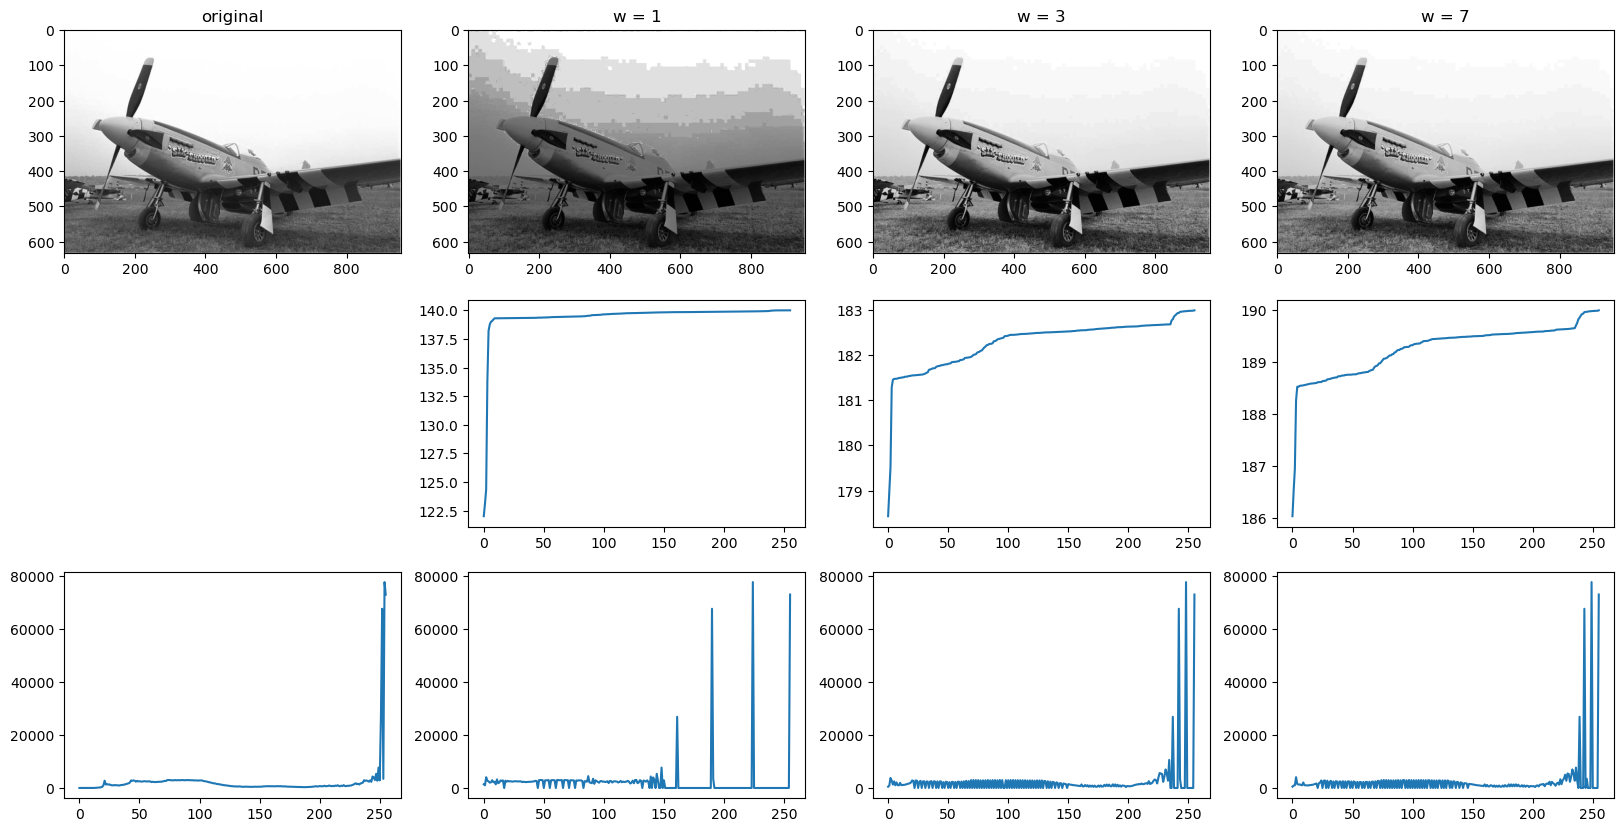

In [22]:
# plot: plane
fig = plt.figure(figsize=(20,10))

plt.subplot(3,4,1)
plt.imshow(X_plane ,cmap='gray')
plt.title('original')

plt.subplot(3,4,2)
plt.imshow(Y_plane_1 , cmap='gray')
plt.title('w = 1')

plt.subplot(3,4,3)
plt.imshow(Y_plane_3, cmap='gray')
plt.title('w = 3')

plt.subplot(3,4,4)
plt.imshow(Y_plane_5, cmap='gray')
plt.title('w = 7')

plt.subplot(3,4,6)
plt.plot(mapxy_plane_1* L_plane_1)

plt.subplot(3,4,7)
plt.plot(mapxy_plane_3* L_plane_3)

plt.subplot(3,4,8)
plt.plot(mapxy_plane_5* L_plane_5)

plt.subplot(3,4,9)
plt.plot(imhist(X_plane))
         
plt.subplot(3,4,10)
plt.plot(imhist(Y_plane_1))

plt.subplot(3,4,11)
plt.plot(imhist(Y_plane_3))

plt.subplot(3,4,12)
plt.plot(imhist(Y_plane_5))

plt.show()

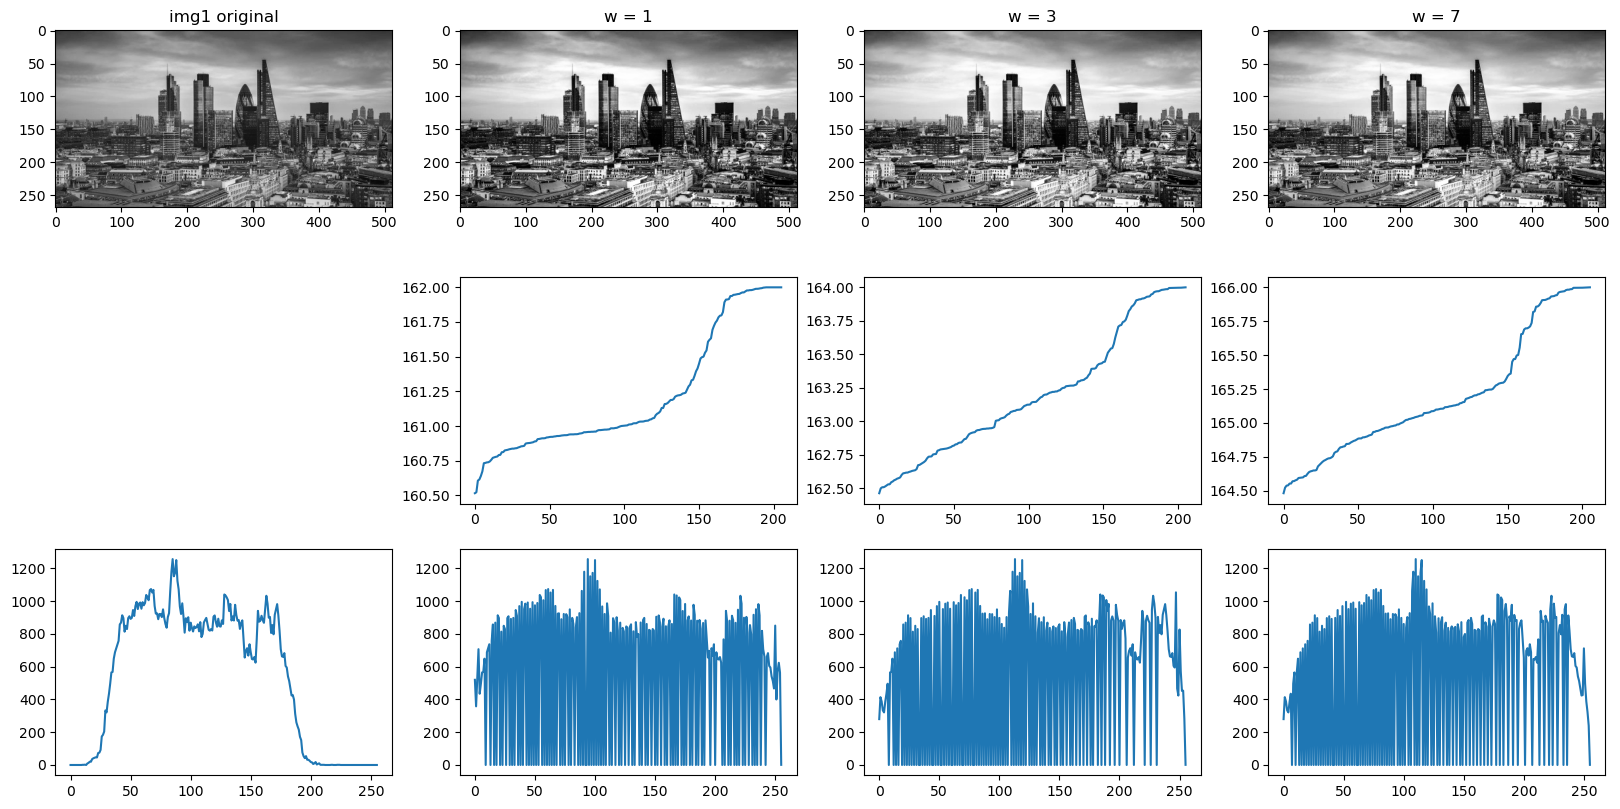

In [27]:
# plot: img1
fig = plt.figure(figsize=(20,10))

plt.subplot(3,4,1)
plt.imshow(X_img1, cmap='gray')
plt.title('img1 original')

plt.subplot(3,4,2)
plt.imshow(Y_img1_1, cmap='gray')
plt.title('w = 1')

plt.subplot(3,4,3)
plt.imshow(Y_img1_3, cmap='gray')
plt.title('w = 3')

plt.subplot(3,4,4)
plt.imshow(Y_img1_5, cmap='gray')
plt.title('w = 7')

plt.subplot(3,4,6)
plt.plot(mapxy_img1_1*L_img1_1)

plt.subplot(3,4,7)
plt.plot(mapxy_img1_3*L_img1_3)

plt.subplot(3,4,8)
plt.plot(mapxy_img1_5*L_img1_5)

plt.subplot(3,4,9)
plt.plot(imhist(X_img1))
         
plt.subplot(3,4,10)
plt.plot(imhist(Y_img1_1))

plt.subplot(3,4,11)
plt.plot(imhist(Y_img1_3))

plt.subplot(3,4,12)
plt.plot(imhist(Y_img1_5))

plt.show()

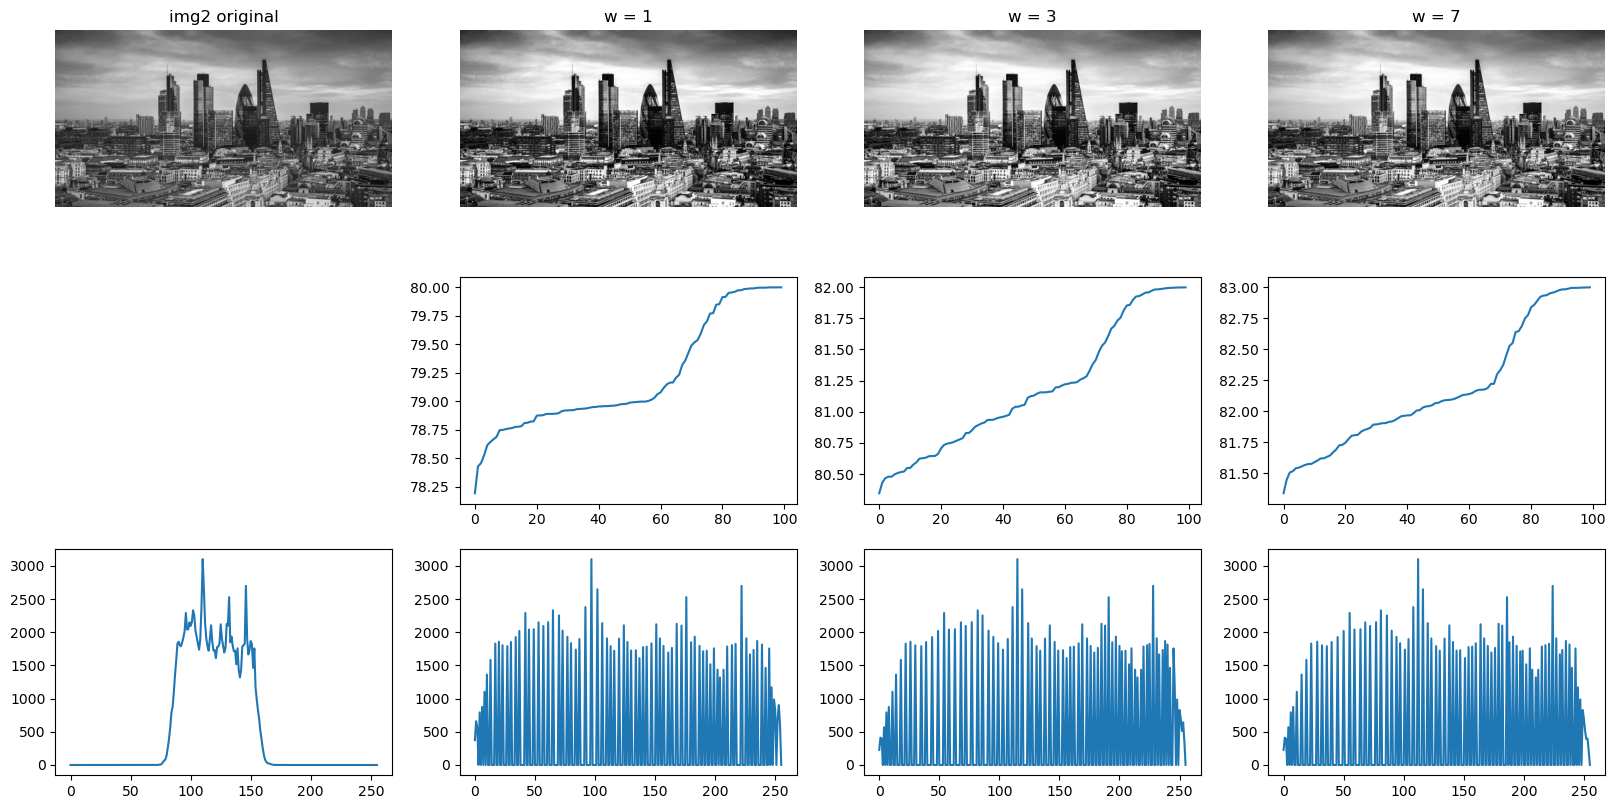

In [28]:
# plot: img2
fig = plt.figure(figsize=(20,10))

plt.subplot(3,4,1)
plt.imshow(X_img2, cmap='gray')
plt.title('img2 original')
plt.axis('off')

plt.subplot(3,4,2)
plt.imshow(Y_img2_1, cmap='gray')
plt.title('w = 1')
plt.axis('off')

plt.subplot(3,4,3)
plt.imshow(Y_img2_3, cmap='gray')
plt.title('w = 3')
plt.axis('off')

plt.subplot(3,4,4)
plt.imshow(Y_img2_5, cmap='gray')
plt.title('w = 7')
plt.axis('off')

plt.subplot(3,4,6)
plt.plot(mapxy_img2_1*L_img2_1)

plt.subplot(3,4,7)
plt.plot(mapxy_img2_3*L_img2_3)

plt.subplot(3,4,8)
plt.plot(mapxy_img2_5*L_img2_5)

plt.subplot(3,4,9)
plt.plot(imhist(X_img2))
         
plt.subplot(3,4,10)
plt.plot(imhist(Y_img2_1))

plt.subplot(3,4,11)
plt.plot(imhist(Y_img2_3))

plt.subplot(3,4,12)
plt.plot(imhist(Y_img2_5))

plt.show()

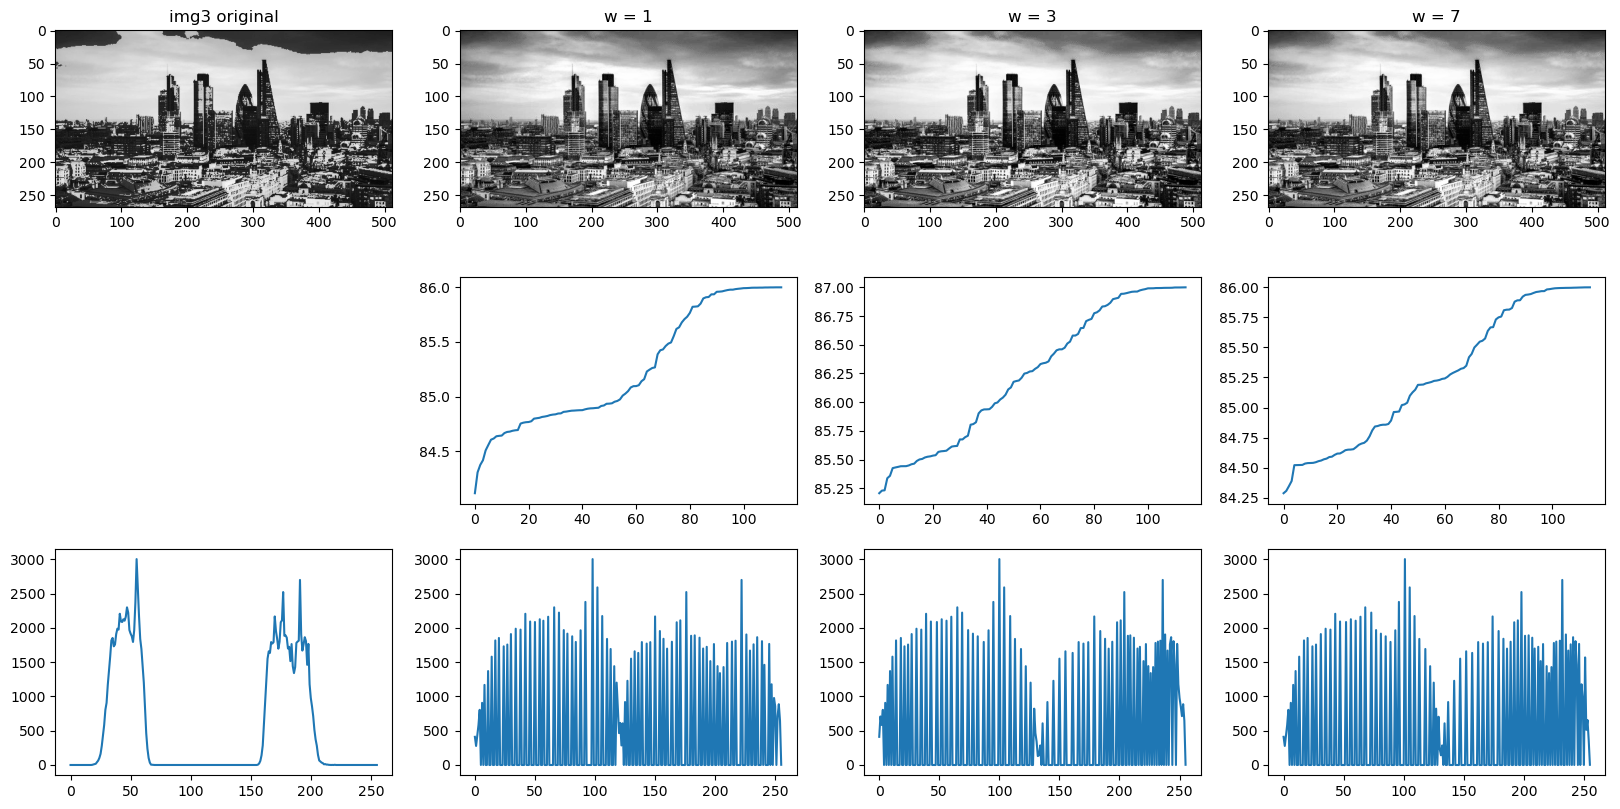

In [29]:
# plot: img3
fig = plt.figure(figsize=(20,10))

plt.subplot(3,4,1)
plt.imshow(X_img3, cmap='gray')
plt.title('img3 original')

plt.subplot(3,4,2)
plt.imshow(Y_img3_1, cmap='gray')
plt.title('w = 1')

plt.subplot(3,4,3)
plt.imshow(Y_img3_3, cmap='gray')
plt.title('w = 3')

plt.subplot(3,4,4)
plt.imshow(Y_img3_5, cmap='gray')
plt.title('w = 7')

plt.subplot(3,4,6)
plt.plot(mapxy_img3_1*L_img3_1)

plt.subplot(3,4,7)
plt.plot(mapxy_img3_3*L_img3_3)

plt.subplot(3,4,8)
plt.plot(mapxy_img3_5*L_img3_1)

plt.subplot(3,4,9)
plt.plot(imhist(X_img3))
         
plt.subplot(3,4,10)
plt.plot(imhist(Y_img3_1))

plt.subplot(3,4,11)
plt.plot(imhist(Y_img3_3))

plt.subplot(3,4,12)
plt.plot(imhist(Y_img3_5))

plt.show()

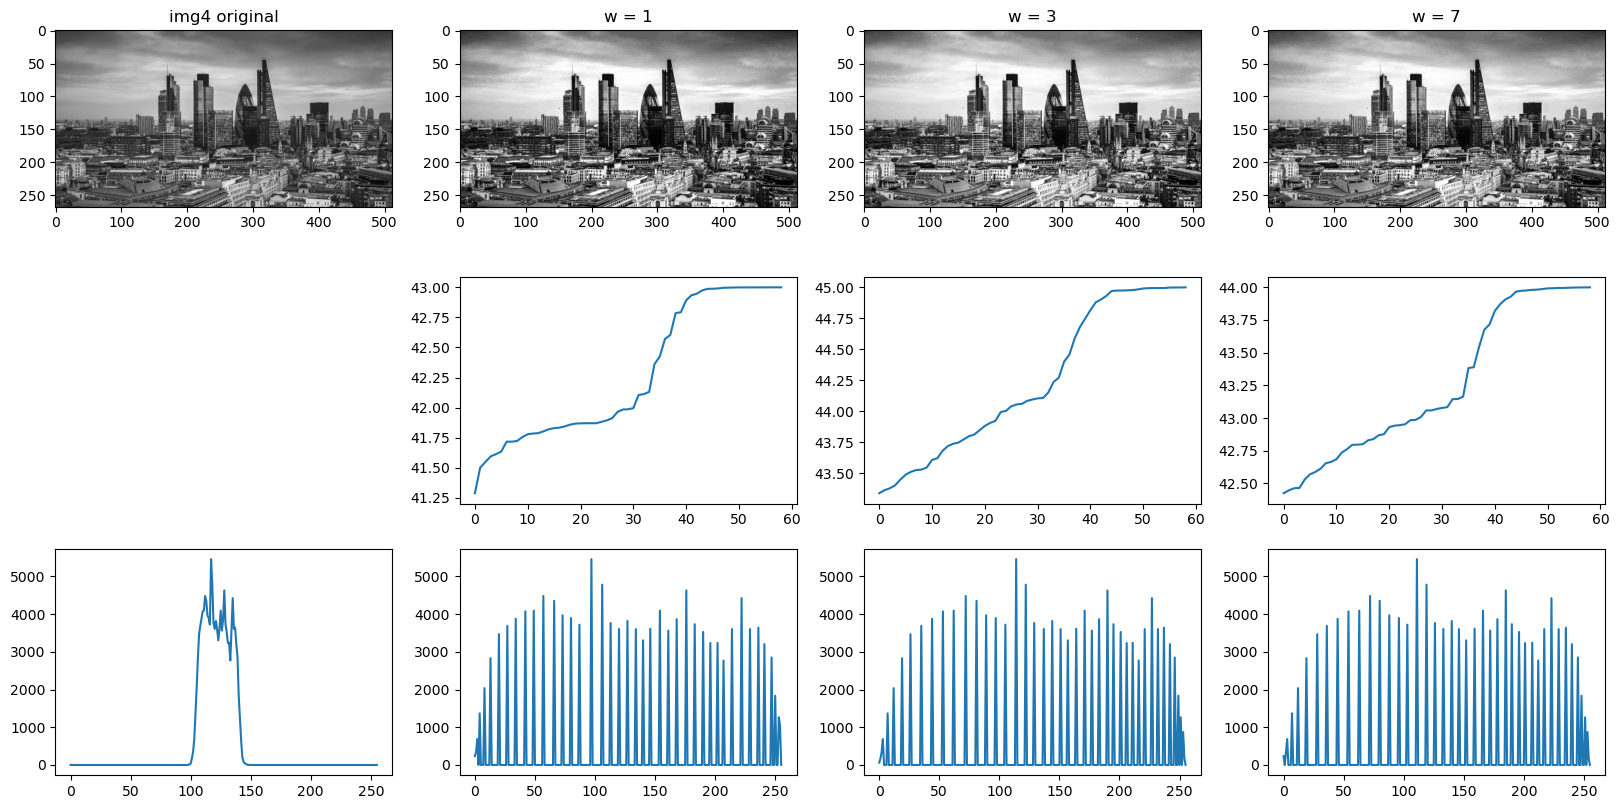

In [31]:
# plot: img4
fig = plt.figure(figsize=(20,10))

plt.subplot(3,4,1)
plt.imshow(X_img1, cmap='gray')
plt.title('img4 original')

plt.subplot(3,4,2)
plt.imshow(Y_img4_1, cmap='gray')
plt.title('w = 1')

plt.subplot(3,4,3)
plt.imshow(Y_img4_3, cmap='gray')
plt.title('w = 3')

plt.subplot(3,4,4)
plt.imshow(Y_img4_5, cmap='gray')
plt.title('w = 7')

plt.subplot(3,4,6)
plt.plot(mapxy_img4_1*L_img4_1)

plt.subplot(3,4,7)
plt.plot(mapxy_img4_3*L_img4_3)

plt.subplot(3,4,8)
plt.plot(mapxy_img4_5*L_img4_5)

plt.subplot(3,4,9)
plt.plot(imhist(X_img4))
         
plt.subplot(3,4,10)
plt.plot(imhist(Y_img4_1))

plt.subplot(3,4,11)
plt.plot(imhist(Y_img4_3))

plt.subplot(3,4,12)
plt.plot(imhist(Y_img4_5))

plt.show()